## I. Data collection, cleaning and processing of meta_Appliances.json

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
df = pd.read_json("meta_Appliances.json", lines=True)
df = df.drop(columns=["feature", "fit", "description", "imageURL", "imageURLHighRes", "tech1", "tech2", "rank", "similar_item"])
df.head()

,category,title,also_buy,brand,also_view,details,main_cat,date,price,asin
0,"[Appliances, Refrigerators, Freezers & Ice Mak...",Tupperware Freezer Square Round Container Set ...,[],Tupperware,[],{},Appliances,"November 19, 2008",,7301113188
1,"[Appliances, Refrigerators, Freezers & Ice Mak...",2 X Tupperware Pure &amp; Fresh Unique Covered...,[],Tupperware,[B004RUGHJW],{},Appliances,"June 5, 2016",$3.62,7861850250
2,"[Appliances, Parts &amp; Accessories]",The Cigar - Moments of Pleasure,[],The Cigar Book,"[B01HCAVSLK, 1632206579]",{},Amazon Home,,$150.26,8792559360
3,"[Appliances, Parts & Accessories]",Caraselle 2X 50G Appliance Descalene,[],Caraselle,[],{},Tools & Home Improvement,"December 17, 2014",.a-box-inner{background-color:#fff}#alohaBuyBo...,9792954481
4,"[Appliances, Parts & Accessories, Range Parts ...",EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,[],EATON Wiring,[],{},Tools & Home Improvement,"January 16, 2007",$3.43,B00002N5EL


### 1. Xem kiểu dữ liệu

In [ ]:
df.dtypes

category     object
title        object
also_buy     object
brand        object
also_view    object
details      object
main_cat     object
date         object
price        object
asin         object
dtype: object

### 2. Đếm số dòng trùng lặp (và xóa nếu có)

In [ ]:
df.astype(str).duplicated().sum()

206

In [ ]:
df.astype(str).drop_duplicates(inplace=True)

### 3. Chuẩn hóa cột category (đưa nhiều thuộc tính trong category về dạng 0 và 1, trong đó 0 là sản phẩm không có cat tương ứng, 1 là có)

In [ ]:
# Chuyển category từ danh sách thành chuỗi phân tách bởi dấu phẩy
df['category'] = df['category'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Tạo ma trận one-hot encoding cho category
df_categories = df['category'].str.get_dummies(sep=', ')

# Chỉ giữ lại các cột thuộc top 20 category
df_top_categories = df_categories[df_categories.sum().nlargest(25).index]

# Gộp với DataFrame gốc
df = pd.concat([df, df_top_categories], axis=1)
df = df.drop(columns=["category"])
df.head()

,title,also_buy,brand,also_view,details,main_cat,date,price,asin,Appliances,...,Range Hoods,Laundry Appliances,Washers & Dryers,Oven Parts & Accessories,Dishwashers,Ice Makers,Cooktops,Freestanding Ranges,Knobs,Range Hood Parts & Accessories
0,Tupperware Freezer Square Round Container Set ...,[],Tupperware,[],{},Appliances,"November 19, 2008",,7301113188,1,...,0,0,0,0,0,0,0,0,0,0
1,2 X Tupperware Pure &amp; Fresh Unique Covered...,[],Tupperware,[B004RUGHJW],{},Appliances,"June 5, 2016",$3.62,7861850250,1,...,0,0,0,0,0,0,0,0,0,0
2,The Cigar - Moments of Pleasure,[],The Cigar Book,"[B01HCAVSLK, 1632206579]",{},Amazon Home,,$150.26,8792559360,1,...,0,0,0,0,0,0,0,0,0,0
3,Caraselle 2X 50G Appliance Descalene,[],Caraselle,[],{},Tools & Home Improvement,"December 17, 2014",.a-box-inner{background-color:#fff}#alohaBuyBo...,9792954481,1,...,0,0,0,0,0,0,0,0,0,0
4,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,[],EATON Wiring,[],{},Tools & Home Improvement,"January 16, 2007",$3.43,B00002N5EL,1,...,0,0,0,0,0,0,0,0,0,0


### 4. Top 10 most product with categories (bỏ Appliances và Parts & Accessories đi vì quá chung chung không thể hiện rõ)

In [ ]:
category_counts = df_categories.sum()
category_counts = category_counts.drop(["Appliances", "Parts & Accessories"], errors='ignore')
category_counts = category_counts.nlargest(10)

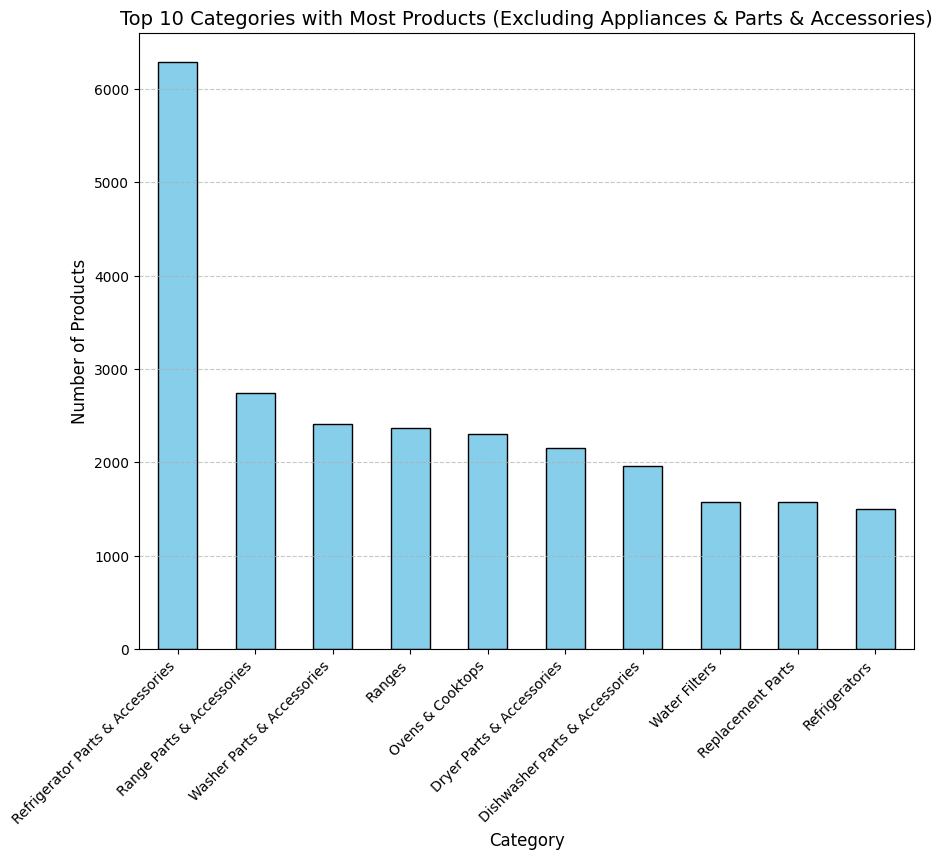

In [ ]:
plt.figure(figsize=(10,8))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Categories with Most Products (Excluding Appliances & Parts & Accessories)', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 5. Price Distribution by Category

##### Làm sạch cột price và tạo một dataframe riêng liên quan đến cột category và price

In [ ]:
# Giữ lại chỉ các số và dấu chấm (giá trị tiền)
df['price_cleaned'] = df['price'].astype(str).str.extract(r'(\d+\.\d+|\d+)')
df['price_cleaned'] = pd.to_numeric(df['price_cleaned'], errors='coerce')

# Loại bỏ NaN và giá trị <= 0
df_clean = df[df['price_cleaned'].notna() & (df['price_cleaned'] > 0)]

In [ ]:
# Kết hợp
top_10_categories = df_top_categories.sum().drop(["Appliances", "Parts & Accessories"], errors='ignore').nlargest(10).index
df_melted = df_clean.melt(id_vars=['price_cleaned'], value_vars=top_10_categories, var_name='Category', value_name='Present')
df_melted = df_melted[df_melted['Present'] == 1]

##### Loại bỏ outlier

In [ ]:
# Loại bỏ outliers bằng IQR
Q1 = df_melted['price_cleaned'].quantile(0.25)
Q3 = df_melted['price_cleaned'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range
df_melted = df_melted[(df_melted['price_cleaned'] >= (Q1 - 1.5 * IQR)) & (df_melted['price_cleaned'] <= (Q3 + 1.5 * IQR))]

##### Vẽ boxplot

C:\Users\huyth\AppData\Local\Temp\ipykernel_17472\2667584918.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='price_cleaned', data=df_melted, palette="Set2")


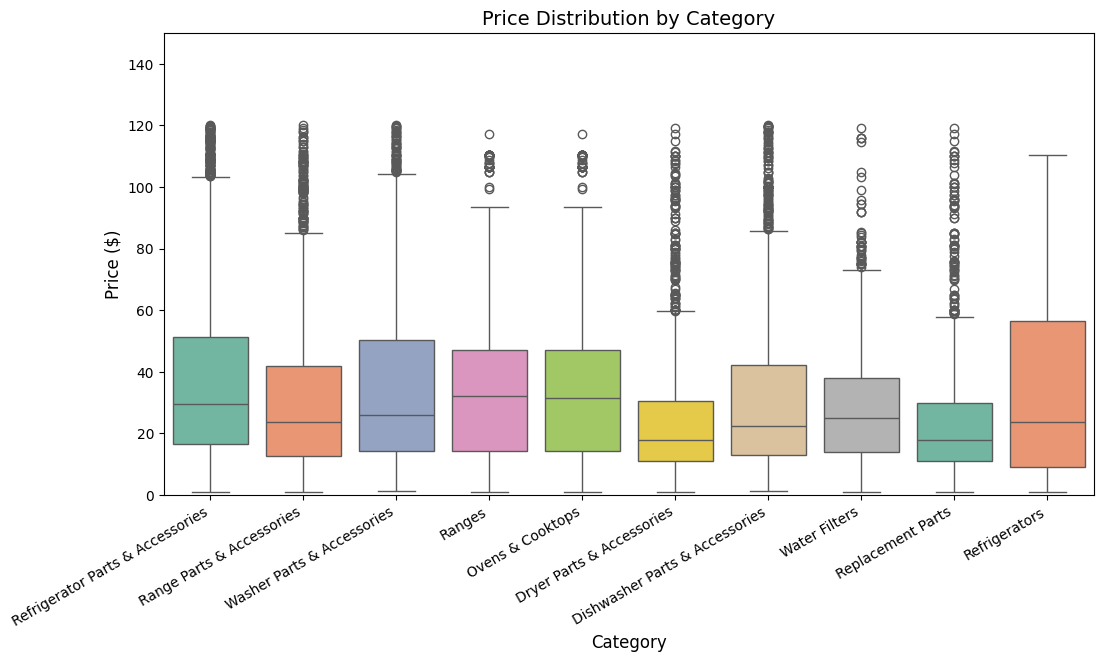

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='price_cleaned', data=df_melted, palette="Set2")

plt.ylim(0, 150)
plt.title('Price Distribution by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=30, ha = 'right')

plt.show()

### 4. Plot: Top 10 brands with most product

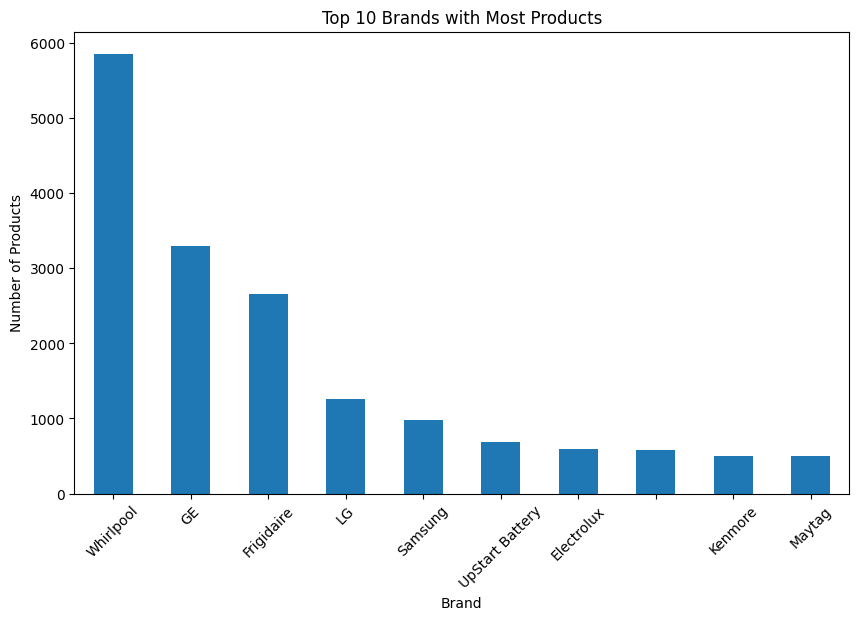

In [ ]:
plt.figure(figsize=(10, 6))
df['brand'].value_counts().nlargest(10).plot(kind='bar')

plt.title('Top 10 Brands with Most Products')
plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()

### 5. PLot: Number of product overtime

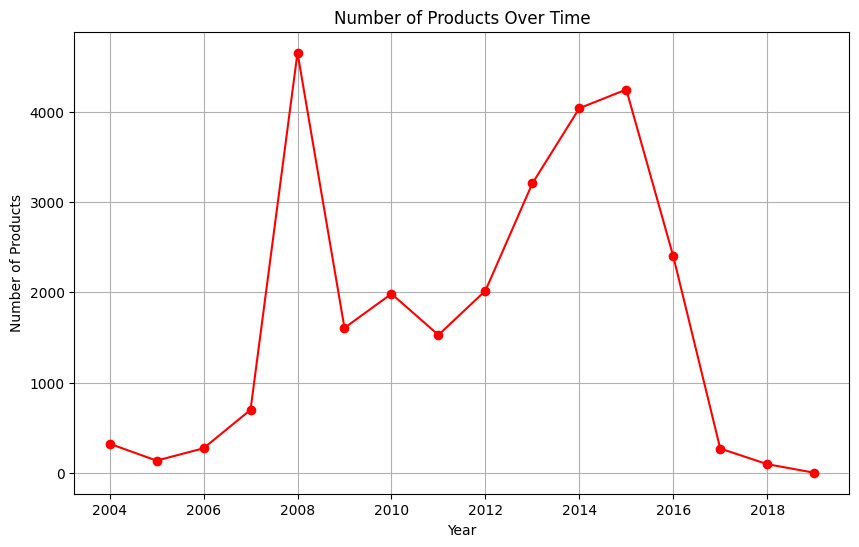

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df[df['date'].dt.year > 2003]

plt.figure(figsize=(10, 6))
yearly_counts = df['date'].dt.year.value_counts().sort_index()
years = yearly_counts.index

# Vẽ biểu đồ
plt.plot(years, yearly_counts.values, marker='o', color='red')
plt.title('Number of Products Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Products')
plt.grid(True)
plt.show()

## II. Data collection, cleaning & processing on Appliances.json

In [ ]:
df2 = pd.read_json("Appliances.json", lines=True)
df2 = df2.drop(columns=["style", "unixReviewTime", "image"])

In [ ]:
df2.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ..."


### 1. Xem kiểu dữ liệu

In [ ]:
df2.dtypes

overall          int64
vote            object
verified          bool
reviewTime      object
reviewerID      object
asin            object
reviewerName    object
reviewText      object
summary         object
dtype: object

### 2. Đếm số dòng trùng lặp (và xóa nếu có)

In [ ]:
df2.astype(str).duplicated().sum()

11416

In [ ]:
df2.astype(str).drop_duplicates(inplace=True)

### 3. Chỉnh lại cột reviewTime cho đúng định dạng

In [ ]:
df2['reviewTime'] = pd.to_datetime(df2['reviewTime'], errors='coerce')

### 4. Plot: Number of review by time

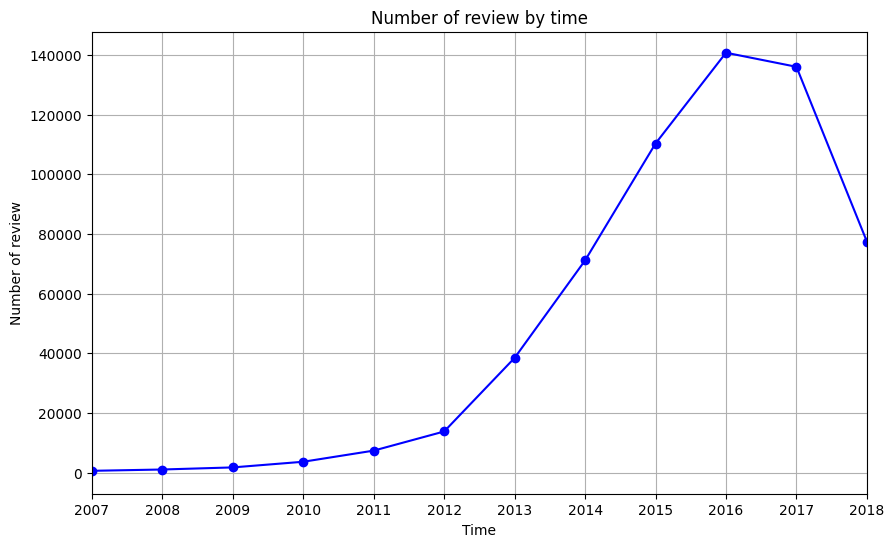

In [ ]:
plt.figure(figsize=(10, 6))
df2['reviewTime'].dt.year.value_counts().sort_index().plot(kind='line', marker='o', color='blue')

plt.title('Number of review by time')
plt.xlabel('Time')
plt.ylabel('Number of review')
plt.grid(True)
plt.xlim(2007, df2['reviewTime'].dt.year.max())

years = range(2007, df2['reviewTime'].dt.year.max() + 1)
plt.xticks(ticks=years, labels=years)
plt.show()

### 5. Gộp hai file json (meta_Appliances & Appliances) lại với nhau, chỉ lấy các cột quan trọng để EDA

In [ ]:
# Chọn các cột cần thiết từ df1 và df2
df_selected = df[['asin', 'brand'] + list(df_top_categories.columns)]
df2_selected = df2[['asin', 'reviewTime', 'reviewerName']]

# Gộp 2 dataframe lại dựa trên asin
df3 = pd.merge(df_selected, df2_selected, on='asin', how='inner')
df3.head()

,asin,brand,Appliances,Parts & Accessories,Refrigerator Parts & Accessories,Range Parts & Accessories,Washer Parts & Accessories,Ranges,Ovens & Cooktops,Dryer Parts & Accessories,...,Oven Parts & Accessories,Dishwashers,Ice Makers,Cooktops,Freestanding Ranges,Knobs,Range Hood Parts & Accessories,overall,reviewTime,reviewerName
0,7301113188,Tupperware,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,2009-03-13,Maha
1,7861850250,Tupperware,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,2017-01-14,Amazon Customer
2,9792954481,Caraselle,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2016-10-16,Kittyrescuer
3,9792954481,Caraselle,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,2015-07-13,Amazon Customer
4,B00002N5EL,EATON Wiring,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,5,2016-01-21,Ron S.


### 6. Plot: Top 10 Categories with Most Reviews

C:\Users\huyth\AppData\Local\Temp\ipykernel_17472\597820200.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="coolwarm")


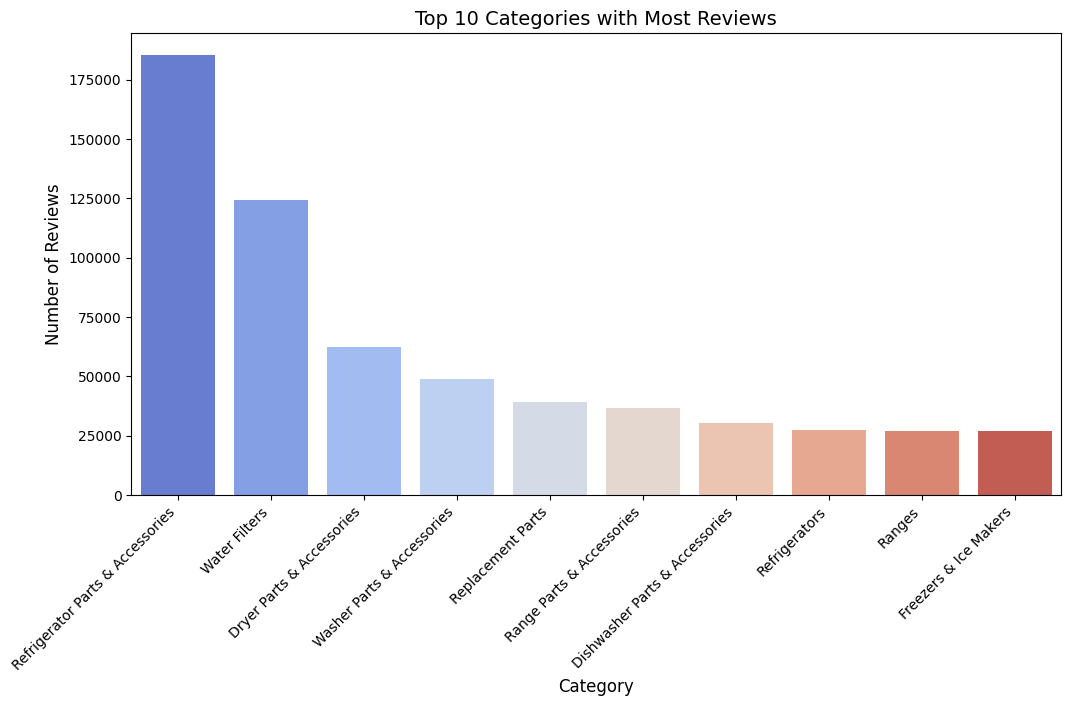

In [ ]:
category_counts = df3.iloc[:, 2:-2].sum().drop(["Appliances", "Parts & Accessories"], errors='ignore').nlargest(10)

plt.figure(figsize=(12,6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="coolwarm")

plt.title("Top 10 Categories with Most Reviews", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

### 7. Plot: Top 10 Brands with Most Reviews

In [ ]:
top_brands = df3['brand'].value_counts().nlargest(10)

C:\Users\huyth\AppData\Local\Temp\ipykernel_17472\2303806099.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.index, y=top_brands.values, palette="deep")


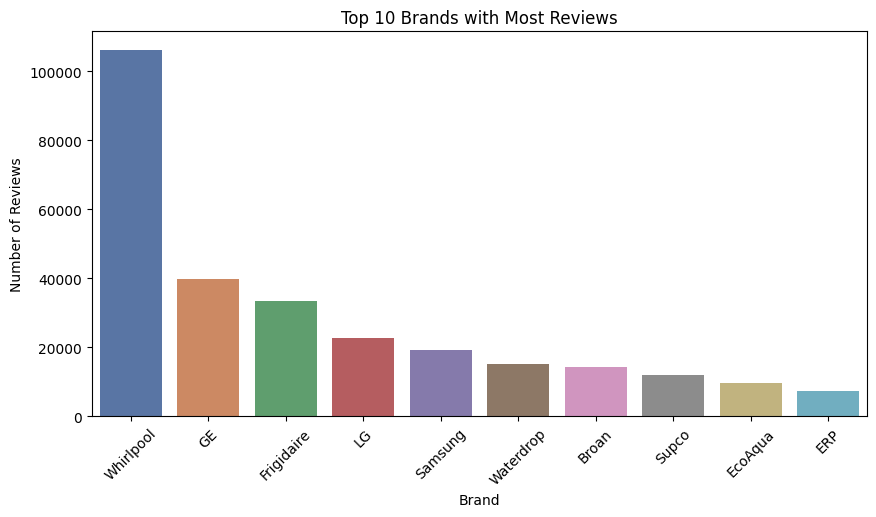

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_brands.index, y=top_brands.values, palette="deep")
plt.xticks(rotation=45)
plt.title("Top 10 Brands with Most Reviews")
plt.xlabel("Brand")
plt.ylabel("Number of Reviews")
plt.show()

### 8. Average Rating of Top 10 Most Reviewed Brands

In [ ]:
# Chọn các cột cần thiết từ df1 và df2 (thêm cột overall)
df_selected = df[['asin', 'brand'] + list(df_top_categories.columns)]
df2_selected = df2[['asin', 'overall', 'reviewTime', 'reviewerName']]

# Gộp 2 dataframe lại dựa trên asin
df3 = pd.merge(df_selected, df2_selected, on='asin', how='inner')

In [ ]:
brand_ratings = df3.groupby("brand")["overall"].mean()

In [ ]:
# Lấy top 10 brands
top_10_brands = df3["brand"].value_counts().nlargest(10).index
brand_ratings = brand_ratings.loc[top_10_brands]

C:\Users\huyth\AppData\Local\Temp\ipykernel_17472\3478344280.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_ratings.index, y=brand_ratings.values, palette="plasma")


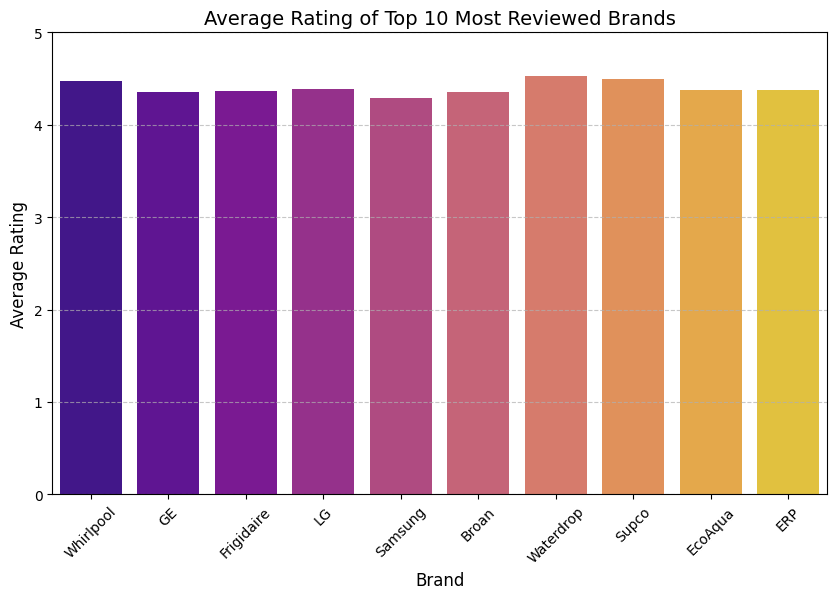

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=brand_ratings.index, y=brand_ratings.values, palette="plasma")

plt.title("Average Rating of Top 10 Most Reviewed Brands", fontsize=14)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.xticks(rotation=45)

plt.ylim(0, 5)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### 9. Top 10 Brands by Revenue

In [ ]:
# Chọn các cột cần thiết từ df1 (đã clean price) và df2 (thêm cột overall)
df_selected = df_clean[['asin', 'brand', 'price_cleaned'] + list(df_top_categories.columns)]
df2_selected = df2[['asin', 'overall', 'reviewTime', 'reviewerName']]

# Gộp 2 dataframe lại dựa trên asin
df3 = pd.merge(df_selected, df2_selected, on='asin', how='inner')

In [ ]:
revenue_by_brand = df3.groupby('brand')['price_cleaned'].sum().sort_values(ascending=False)
revenue_by_brand_df = revenue_by_brand.reset_index()
revenue_by_brand_df.head()

,brand,price_cleaned
0,Whirlpool,3231872.15
1,Samsung,1396052.71
2,GE,1298573.08
3,Frigidaire,1268281.93
4,LG,744220.58


C:\Users\huyth\AppData\Local\Temp\ipykernel_17472\2217672121.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')


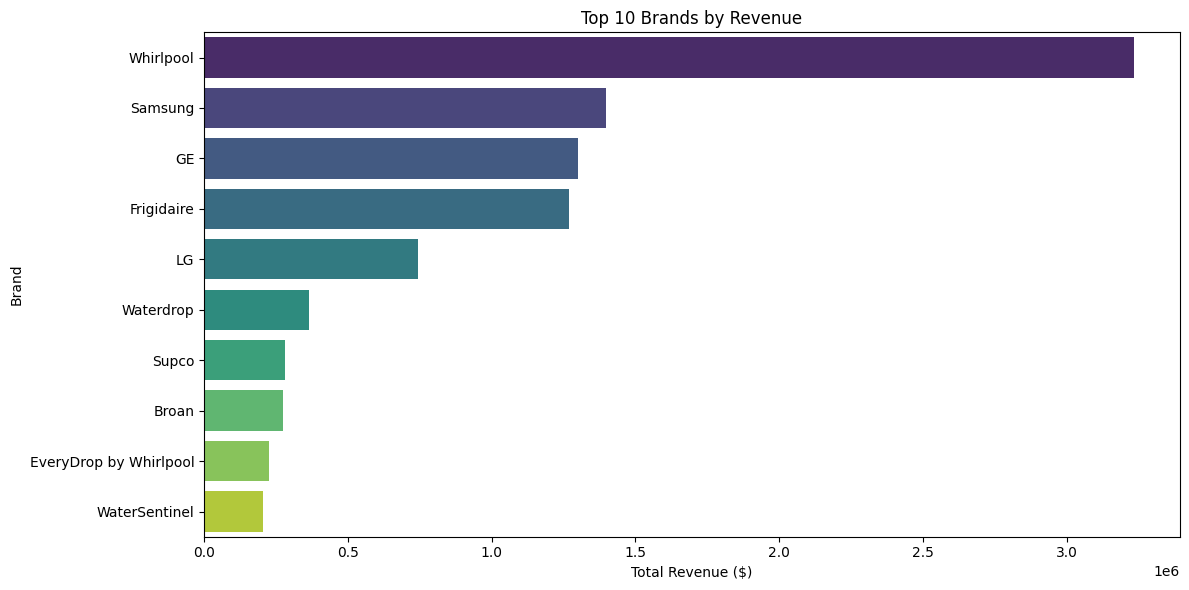

In [ ]:
top_brands = revenue_by_brand.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')
plt.xlabel('Total Revenue ($)')
plt.ylabel('Brand')
plt.title('Top 10 Brands by Revenue')
plt.tight_layout()
plt.show()

## III. Feature Engineering

### 1.  Review Trends Over Time for Top 5 Categories (Biểu đồ xu hướng thời gian cho 5 category)

In [ ]:
df3 = df3[(df3['reviewTime'].dt.year >= 2012) & (df3['reviewTime'].dt.year <= 2017)]
df3['year_month'] = df3['reviewTime'].dt.to_period('M')

In [ ]:
# Xác định category columns
non_category_columns = ['asin', 'brand', 'overall', 'reviewerName', 'reviewTime']
category_columns = [col for col in df3.columns if col not in non_category_columns and df3[col].dtype in ['int64', 'float64']]

In [ ]:
# Chọn top 5 categories phổ biến nhất và kết hợp thời gian vào
category_counts = df3[category_columns].sum().drop(["Appliances", "Parts & Accessories"], errors='ignore')
top_categories = category_counts.nlargest(5).index.tolist()
category_trends = df3.groupby('year_month')[top_categories].sum()
category_trends_smooth = category_trends.rolling(window=3, min_periods=1).mean()

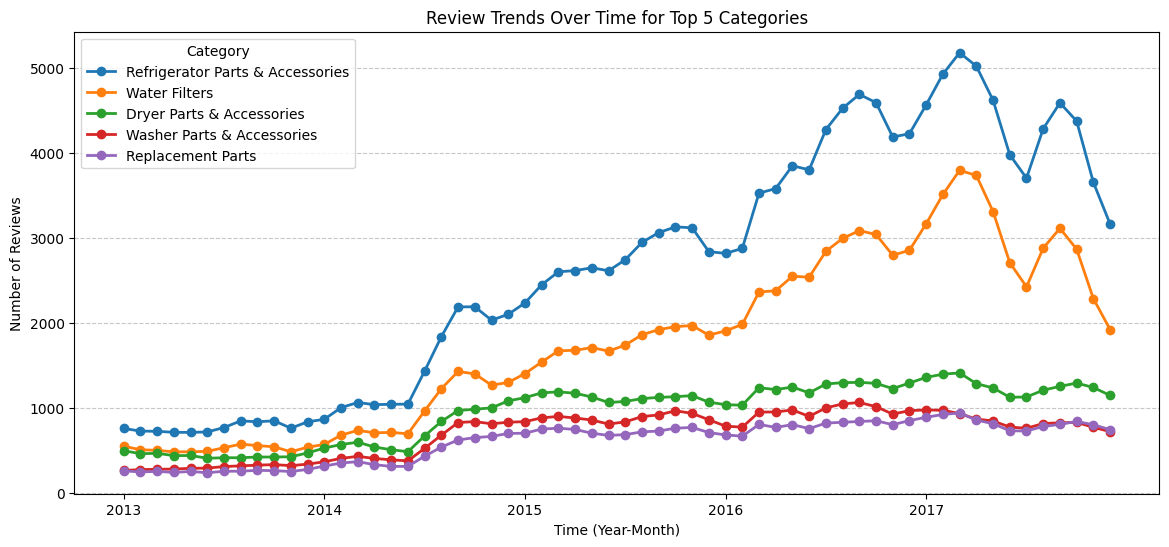

In [ ]:
plt.figure(figsize=(14, 6))
for category in top_categories:
    plt.plot(category_trends_smooth.index.astype(str), category_trends_smooth[category], marker='o', label=category, linewidth=2)
plt.title("Review Trends Over Time for Top 5 Categories")
plt.xlabel("Time (Year-Month)")
plt.ylabel("Number of Reviews")
year_labels = [str(year) for year in range(df3['reviewTime'].dt.year.min(), df3['reviewTime'].dt.year.max() + 1)]
year_indices = [str(year) + '-01' for year in year_labels]
plt.xticks(year_indices, year_labels)
plt.legend(title="Category", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 2. Top 15 từ khóa được người dùng đánh giá nhiều nhất

In [ ]:
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
# Tải stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

In [ ]:
# Gộp toàn bộ reviewText thành một chuỗi lớn, loại bỏ giá trị NaN
all_text = " ".join(df2["reviewText"].dropna().astype(str))

In [ ]:
# Loại bỏ ký tự đặc biệt, chỉ giữ lại chữ cái và số, chuyển thành chữ thường
words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())
filtered_words = [word for word in words if word not in stop_words]

In [ ]:
# Đếm tần suất từ xuất hiện và xuất df
word_freq = Counter(filtered_words)
top_15_keywords = word_freq.most_common(15)
df_keywords = pd.DataFrame(top_15_keywords, columns=["Keyword", "Frequency"])
df_keywords.head()

,Keyword,Frequency
0,great,142027
1,one,110026
2,works,102438
3,water,100782
4,fit,87598


C:\Users\huyth\AppData\Local\Temp\ipykernel_13252\541079973.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Keyword", data=df_keywords, palette="viridis")


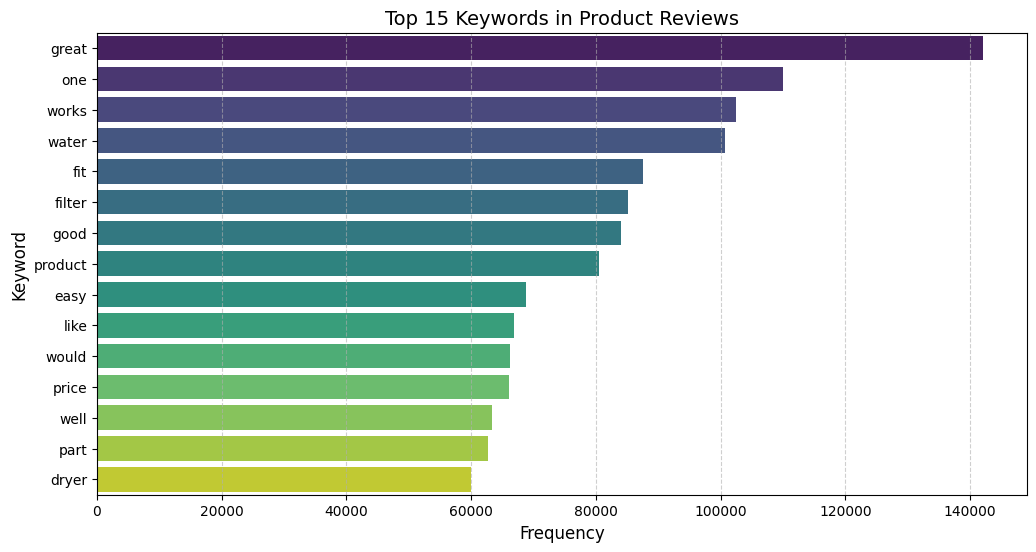

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Keyword", data=df_keywords, palette="viridis")

# Thêm tiêu đề và nhãn
plt.title("Top 15 Keywords in Product Reviews", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Keyword", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

### 3. Ma trận tương quan giữa các category (top 15) (phân theo người dùng)

In [ ]:
df_matrix = df3.drop(columns=["asin", "brand", "Appliances","Parts & Accessories", "overall", "reviewTime", "reviewerName", "Ranges"])
df_matrix = df_matrix.loc[:, ~df_matrix.columns.duplicated()]

In [ ]:
# Select only numeric columns
numeric_df = df_matrix.select_dtypes(include=[float, int])

# Compute the correlation matrix for numeric columns
correlation_matrix = numeric_df.corr()

In [ ]:
# Select top 15 categories
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
top_15_corr = corr_pairs.sort_values(ascending=False).head(15)
top_15_corr

Refrigerators                     Freezers & Ice Makers               0.988267
Freezers & Ice Makers             Refrigerators                       0.988267
Laundry Appliances                Washers & Dryers                    0.970540
Washers & Dryers                  Laundry Appliances                  0.970540
Dryer Parts & Accessories         Replacement Parts                   0.753432
Replacement Parts                 Dryer Parts & Accessories           0.753432
Water Filters                     Refrigerator Parts & Accessories    0.743327
Refrigerator Parts & Accessories  Water Filters                       0.743327
Ovens & Cooktops                  Range Hoods                         0.677759
Range Hoods                       Ovens & Cooktops                    0.677759
Refrigerators                     Ice Makers                          0.489778
Ice Makers                        Refrigerators                       0.489778
                                  Freezers & Ice Mak

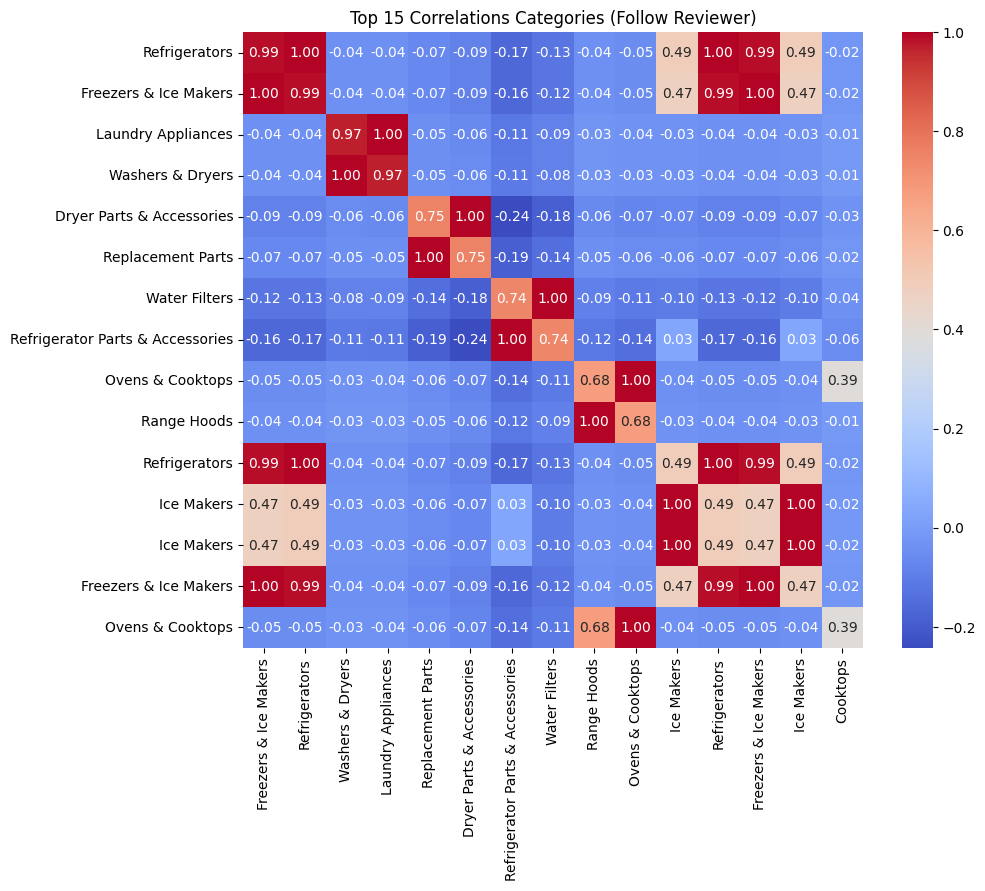

In [ ]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.loc[top_15_corr.index.get_level_values(0), top_15_corr.index.get_level_values(1)], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Top 15 Correlations Categories (Follow Reviewer)")
plt.show()